In [68]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats

In [69]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood,num_tasks, rank = 0):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=rank
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [70]:
import re
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df_x = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 0, usecols = [1,2,3,4])
df_x.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_x.columns]
print(len(df_x))
df_x.head()

24


,Buffer_Type,pH,Sugar_Salt,Additive
0,Ace,4.5,4% Sorbitol,Arginine
1,Ace,4.5,4% Sorbitol,Glycine
2,Ace,5.0,4% Sorbitol,Arginine
3,Ace,5.0,4% Sorbitol,Glycine
4,Ace,5.0,0.1M NaCl,Glycine


In [71]:

df_y_1 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [1,4,7],skiprows = lambda x: x in [1])
df_y_1.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_y_1.columns]
print(len(df_y_1))
print(df_y_1.head())

df_y_2 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [2,5,8],skiprows = lambda x: x in [1])
df_y_2.columns = df_y_1.columns
print(len(df_y_2))
print(df_y_2.head())

df_y_3 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [3,6,9],skiprows = lambda x: x in [1])
df_y_3.columns = df_y_1.columns
print(len(df_y_3))
print(df_y_3.head())



24
   _Dimer_HMW_  _Monomer  _LMW
0          2.4      95.1   2.5
1          0.8      97.3   2.0
2          3.2      94.3   2.6
3          1.4      96.7   1.9
4          4.2      93.3   2.5
24
   _Dimer_HMW_  _Monomer  _LMW
0          1.6      96.2   2.2
1          1.1      96.6   2.2
2          2.0      95.6   2.4
3          1.4      96.4   2.3
4          2.3      95.2   2.4
24
   _Dimer_HMW_  _Monomer  _LMW
0          1.8      93.8   4.4
1          0.7      95.1   4.2
2          2.7      93.4   3.9
3          1.3      95.0   3.6
4          3.4      92.7   4.0


In [72]:
cols_feature01 = list(df_x.columns)
cols_target = list(df_y_1.columns)[0:2]
#cols_target = ['UP_SEC_HMW','UP_SEC_LMW']
cols_cate = ['Buffer_Type',
 'Sugar_Salt',
 'Additive']

In [73]:
total_df_y_long = pd.concat((df_y_1[cols_target],df_y_2[cols_target],df_y_3[cols_target]),axis = 0)
total_df_y_long.reset_index(inplace = True, drop = True)
total_df_y_long

,_Dimer_HMW_,_Monomer
0,2.4,95.1
1,0.8,97.3
2,3.2,94.3
3,1.4,96.7
4,4.2,93.3
...,...,...
67,3.3,92.3
68,3.7,92.3
69,3.6,92.2
70,4.2,90.8


In [74]:
df_y_1.columns = [c+'_1' for c in df_y_1.columns]
df_y_2.columns = [c+'_2' for c in df_y_2.columns]
df_y_3.columns = [c+'_3' for c in df_y_3.columns]


In [75]:
total_df_y = pd.concat((df_y_1[['_Dimer_HMW__1','_Monomer_1']],
                        df_y_2[['_Dimer_HMW__2','_Monomer_2']],
                        df_y_3[['_Dimer_HMW__3','_Monomer_3']]),axis = 1)

display(total_df_y.head())
"""
#convert categorical columns to labels
for x_name in cols_cate:
    labels, categories = factorize(df_x[x_name])
    df_x[x_name+"_label"] = labels
df_x.drop(cols_cate,axis = 1,inplace = True)

display(df_x.head())
"""

,_Dimer_HMW__1,_Monomer_1,_Dimer_HMW__2,_Monomer_2,_Dimer_HMW__3,_Monomer_3
0,2.4,95.1,1.6,96.2,1.8,93.8
1,0.8,97.3,1.1,96.6,0.7,95.1
2,3.2,94.3,2.0,95.6,2.7,93.4
3,1.4,96.7,1.4,96.4,1.3,95.0
4,4.2,93.3,2.3,95.2,3.4,92.7


'\n#convert categorical columns to labels\nfor x_name in cols_cate:\n    labels, categories = factorize(df_x[x_name])\n    df_x[x_name+"_label"] = labels\ndf_x.drop(cols_cate,axis = 1,inplace = True)\n\ndisplay(df_x.head())\n'

In [76]:
#onehot encoding
df_x = pd.get_dummies(df_x, columns = cols_cate)
#print(total_df.head())
df_x.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_x.columns]
#df_x.drop(cols_cate,axis = 1,inplace = True)
#convert boolean True False to 0 1
bool_cols = df_x.select_dtypes(include='bool').columns
df_x[bool_cols] = df_x[bool_cols].astype(int)
print(df_x.head())



    pH  Buffer_Type_Ace  Buffer_Type_Cit  Buffer_Type_His  Buffer_Type_Phos  \
0  4.5                1                0                0                 0   
1  4.5                1                0                0                 0   
2  5.0                1                0                0                 0   
3  5.0                1                0                0                 0   
4  5.0                1                0                0                 0   

   Sugar_Salt_0_1M_NaCl  Sugar_Salt_4_Sorbitol  Additive_Arginine  \
0                     0                      1                  1   
1                     0                      1                  0   
2                     0                      1                  1   
3                     0                      1                  0   
4                     1                      0                  0   

   Additive_Glycine  
0                 0  
1                 1  
2                 0  
3                 1  


In [77]:
cols_feature_new = df_x.columns
cols_target_new = total_df_y.columns
#cols_target_new = ['UP_SEC_HMW_1','UP_SEC_LMW_1',	'UP_SEC_HMW_3',	'UP_SEC_LMW_3','UP_SEC_HMW_5','UP_SEC_LMW_5']

In [78]:
ls_model = ['rf','simpleGP','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['label','ohe','LVGP','LMGP']
ls_remove_pred_outlier = [0,1]
ls_output_rank_option = [1,2]
ls_task_rank_option = [1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_split_option = ['mix','separate'] #mix: combine all tasks first then do train, test split (could stratify task?) #separate, do train-test-split first, then combine tasks
ls_stratify_task = ['not-stratify','stratify-x','stratify-y','stratify-xy']


model_option = 'multi-task-single-output'
x_scale_option = 'x-minmax'
y_scale_option = 'y-stand'
cate_transform_option = 'ohe'
#remove_pred_outlier_option= 0

#output_rank_option = 1 #if 0, no correlation between output
task_rank_option = 2#if 0, no correlation between tasks
lik_rank_option = 1
split_option = 'mix'
stratify_option = 'stratify-x'
noise_option = 0#0.2 #noise percentage

model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_transform_label = 'cate_transform_'+cate_transform_option

if model_option == 'multi-task-single-output' or  model_option =='multi-task-multi-output':
        task_rank_label = 'task_rank_'+str(task_rank_option)
        lik_rank_label = 'lik_rank_'+str(lik_rank_option)
else:
        task_rank_label = ''
        lik_rank_label = ''

if noise_option>0:
        noise_label = 'noise_'+str(noise_option)
else:
        noise_label = ''

random_state_option = 1
random_state_label = 'split_random_state_'+str(random_state_option)

folder_name = '-'.join([model_label,random_state_label,x_scale_label,y_scale_label,cate_transform_label,
                        task_rank_label,lik_rank_label,noise_label])

figPath = 'output/harpoon-250925/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

Creating folder output/harpoon-250925/multi-task-single-output-split_random_state_1-x-minmax-y-stand-cate_transform_ohe-task_rank_2-lik_rank_1-


In [79]:
np.random.seed(42)
N = len(df_x)
#percentage = 0.05
if noise_option>0:
#create data with noise
    df_X_syn = df_x.copy()
    for col in df_x.columns.difference(['task_ind']):
        df_X_syn[col] = df_X_syn[col] + np.random.normal(0, df_X_syn[col].std(), N) * noise_option

    df_Y_syn= total_df_y.copy()
    for col in total_df_y.columns:
        df_Y_syn[col] = df_Y_syn[col] + np.random.normal(0, df_Y_syn[col].std(), N) * noise_option

In [80]:
##Split the data into training and testing sets
if noise_option>0:
    df_total_X = pd.concat((df_x,df_X_syn))
    df_total_Y = pd.concat((total_df_y,df_Y_syn))
else:
    df_total_X = df_x
    df_total_Y = total_df_y
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_total_X, df_total_Y, test_size=0.2, random_state=random_state_option)

In [81]:
print(df_total_X.shape)
print(df_total_Y.shape)

(24, 9)
(24, 6)


array([[<Axes: title={'center': 'pH'}>,
        <Axes: title={'center': 'Buffer_Type_Ace'}>,
        <Axes: title={'center': 'Buffer_Type_Cit'}>],
       [<Axes: title={'center': 'Buffer_Type_His'}>,
        <Axes: title={'center': 'Buffer_Type_Phos'}>,
        <Axes: title={'center': 'Sugar_Salt_0_1M_NaCl'}>],
       [<Axes: title={'center': 'Sugar_Salt_4_Sorbitol'}>,
        <Axes: title={'center': 'Additive_Arginine'}>,
        <Axes: title={'center': 'Additive_Glycine'}>]], dtype=object)

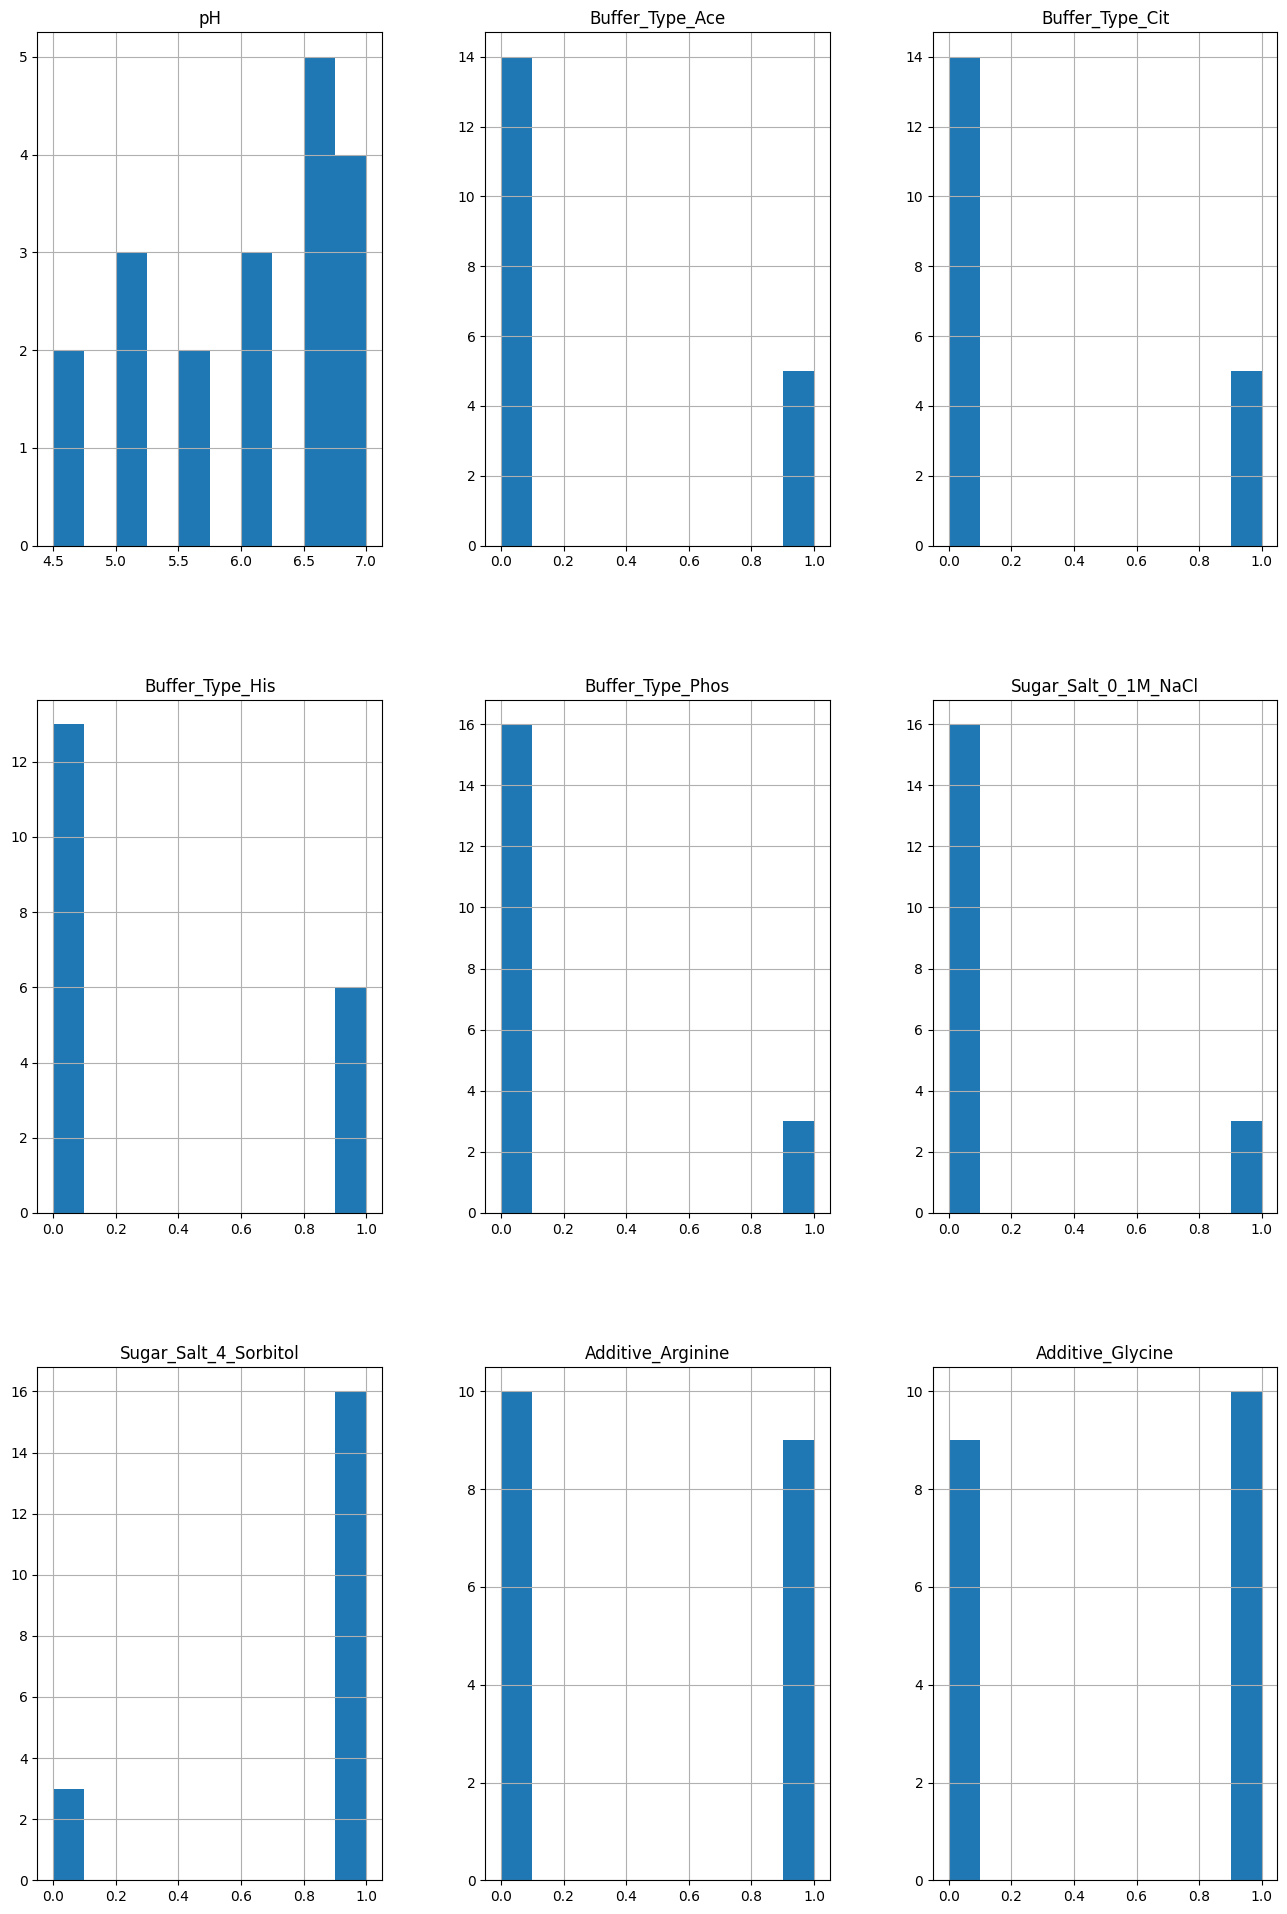

In [82]:
df_X_train.hist(figsize = (16,24))

In [83]:
# scale features
#x_mm_scaler = MinMaxScaler()
#keep the last task indices column untouched !!!



xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),df_X_train.columns.difference(['task_ind']))], 
                         remainder = 'passthrough')
#scaled_X_train=x_mm_scaler.fit_transform(df_X_train) 
#scaled_X_test=x_mm_scaler.transform(df_X_test)

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)

total_mean = df_y_train.iloc[:,[0,2,4]].to_numpy().mean()
total_std = df_y_train.iloc[:,[0,2,4]].to_numpy().std()
#if y_scale_option==1:
if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    scaled_y_test = df_y_test.to_numpy()

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: title={'center': '3'}>],
       [<Axes: title={'center': '4'}>, <Axes: title={'center': '5'}>]],
      dtype=object)

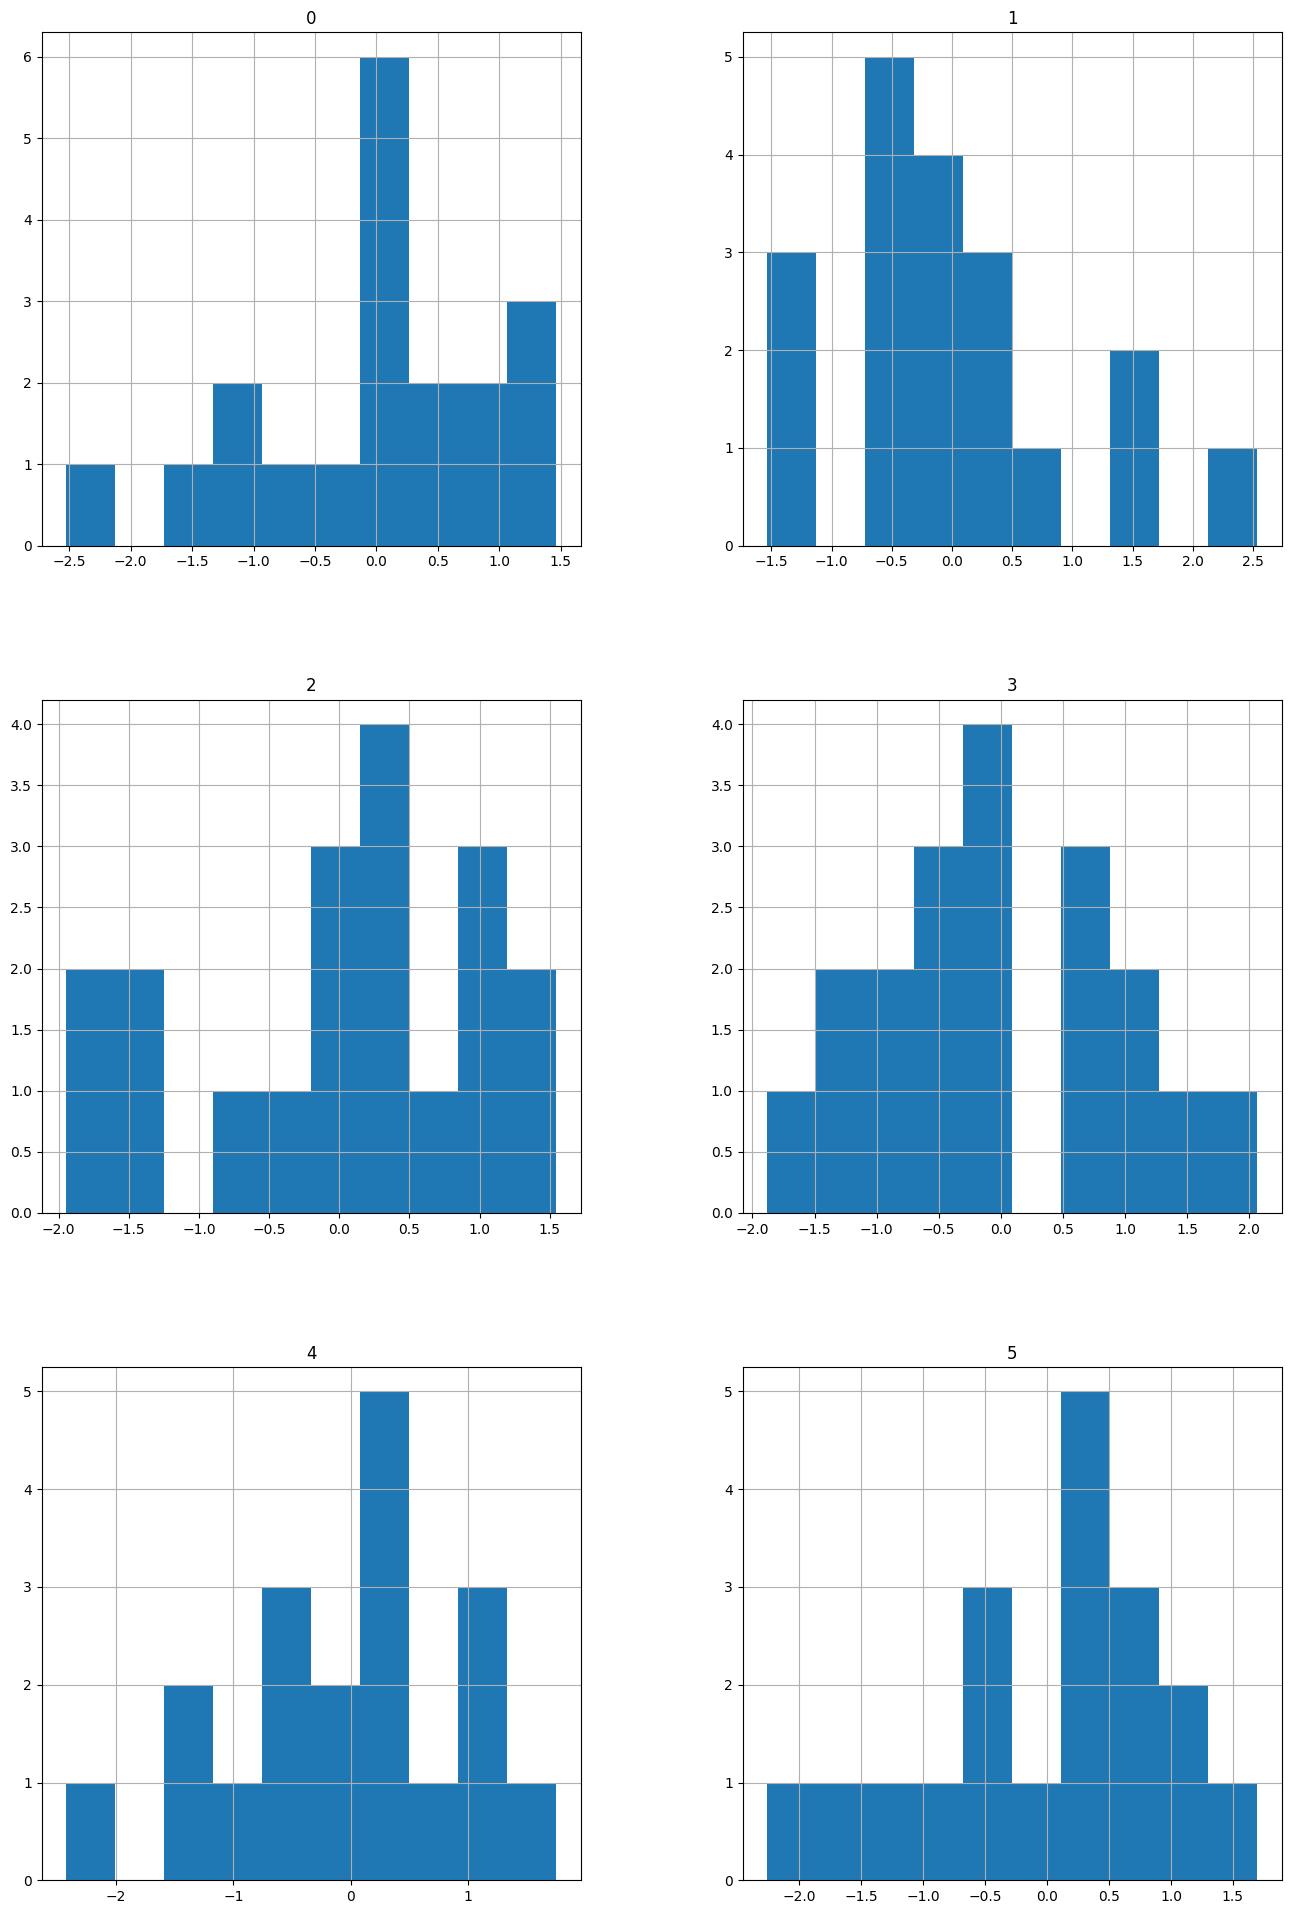

In [84]:
df_scaled_y_train = pd.DataFrame(scaled_y_train)
df_scaled_y_train.hist(figsize = (16,24))

array([[<Axes: title={'center': '_Dimer_HMW__1'}>,
        <Axes: title={'center': '_Monomer_1'}>],
       [<Axes: title={'center': '_Dimer_HMW__2'}>,
        <Axes: title={'center': '_Monomer_2'}>],
       [<Axes: title={'center': '_Dimer_HMW__3'}>,
        <Axes: title={'center': '_Monomer_3'}>]], dtype=object)

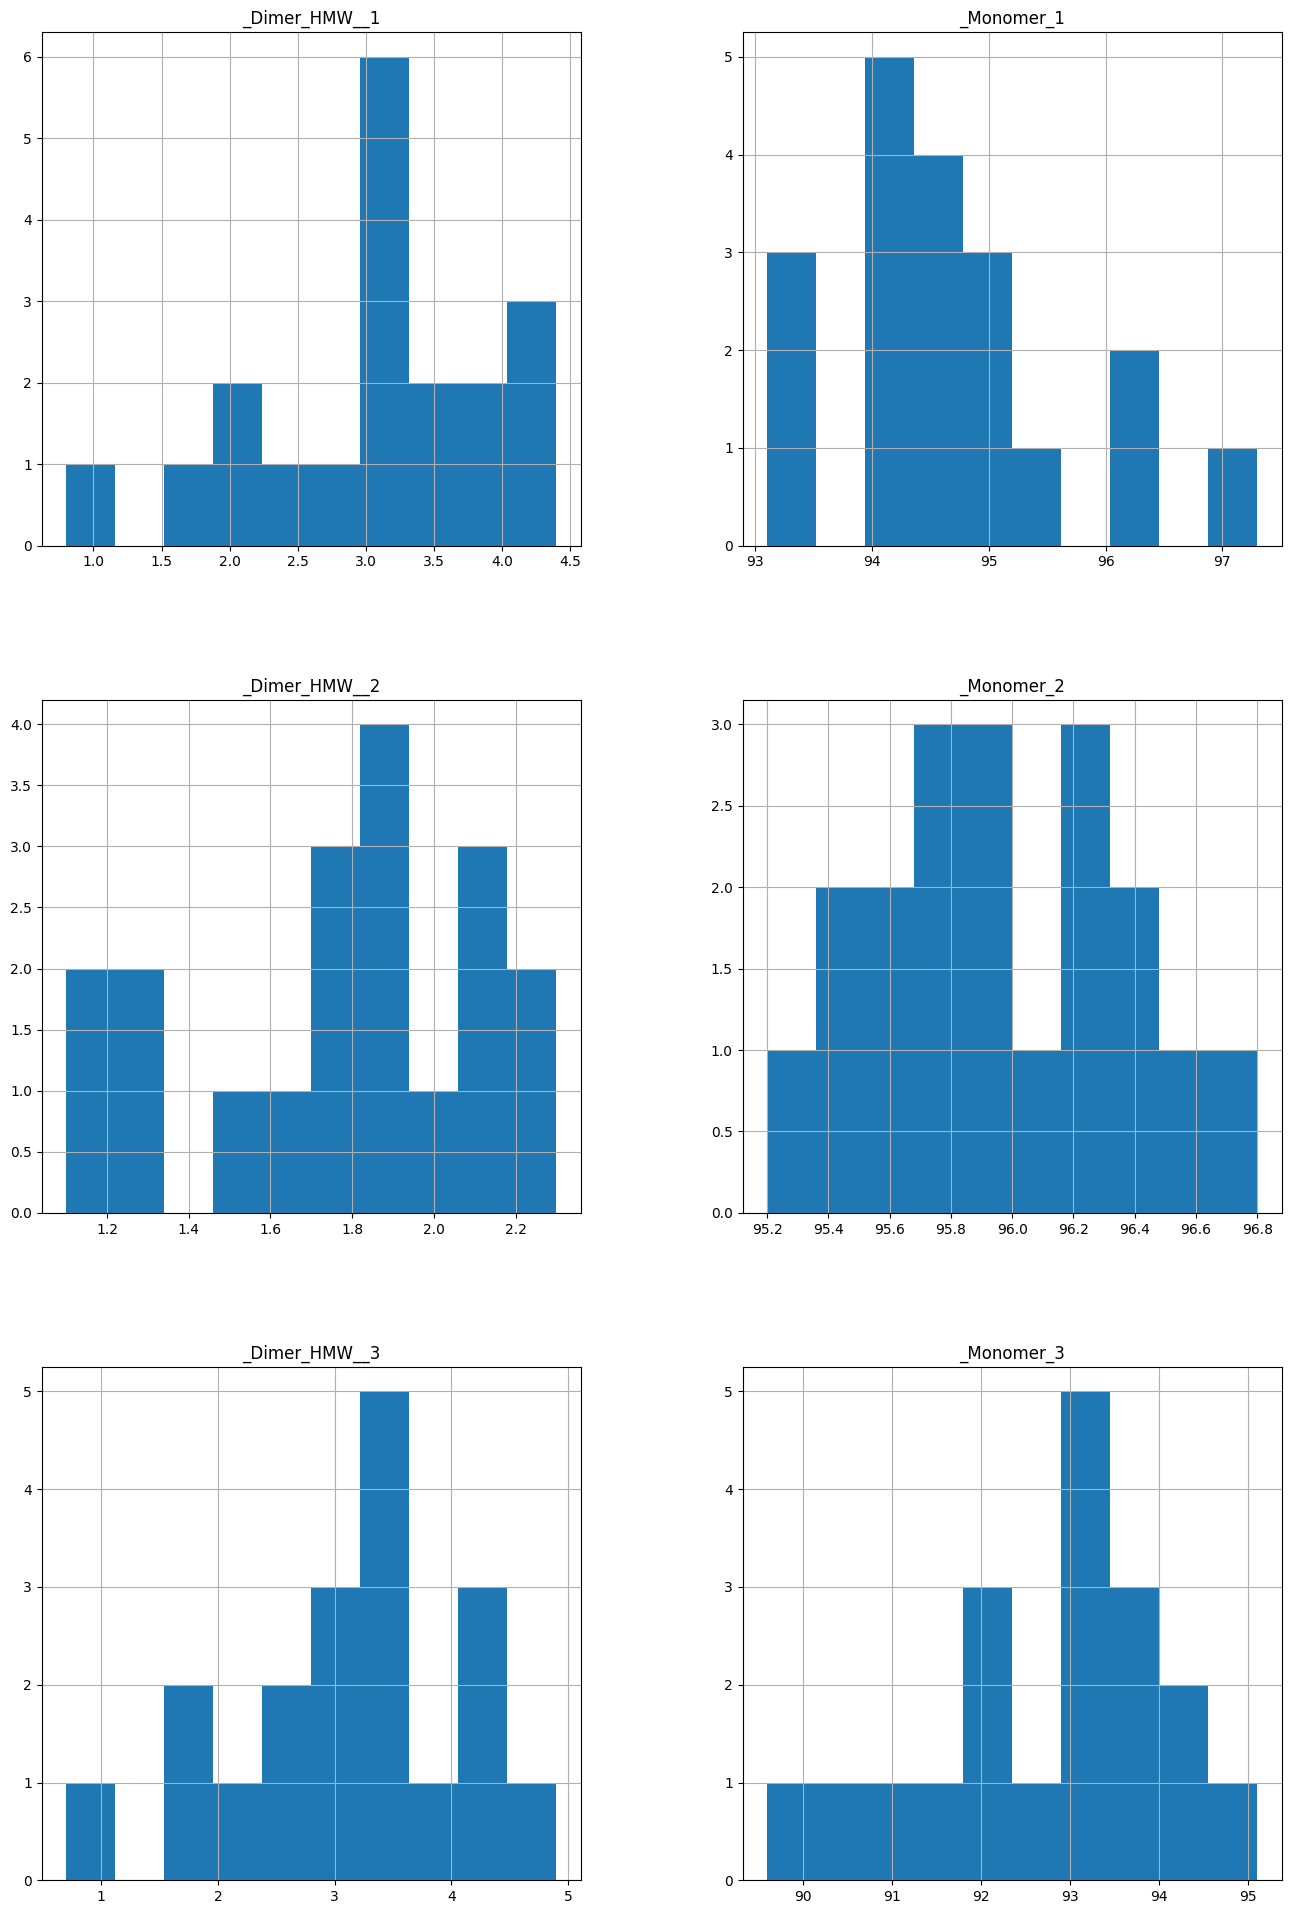

In [85]:
df_y_train.hist(figsize = (16,24))

In [86]:
#if y_scale_option>0:
if y_scale_label != 'no-y-scale':
    t_train_y = torch.Tensor(scaled_y_train)
else:
    t_train_y = torch.Tensor(df_y_train.to_numpy())

#if x_scale_option>0:
if x_scale_label != 'no-x-scale':
    t_train_x = torch.Tensor(scaled_X_train)
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_train_x = torch.Tensor(df_X_train.to_numpy())
    t_test_x = torch.Tensor(df_X_test.to_numpy())

In [87]:
num_outputs = t_train_y.shape[-1]

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs,rank = lik_rank_option)
model = MultitaskGPModel(t_train_x, t_train_y, likelihood, num_tasks= 6, rank = task_rank_option)

Iter 1/300 - Loss: 0.411
Iter 2/300 - Loss: 0.545
Iter 3/300 - Loss: 0.428
Iter 4/300 - Loss: 0.444
Iter 5/300 - Loss: 0.477
Iter 6/300 - Loss: 0.468
Iter 7/300 - Loss: 0.441
Iter 8/300 - Loss: 0.423
Iter 9/300 - Loss: 0.422
Iter 10/300 - Loss: 0.435
Iter 11/300 - Loss: 0.445
Iter 12/300 - Loss: 0.443
Iter 13/300 - Loss: 0.433
Iter 14/300 - Loss: 0.424
Iter 15/300 - Loss: 0.420
Iter 16/300 - Loss: 0.423
Iter 17/300 - Loss: 0.426
Iter 18/300 - Loss: 0.427
Iter 19/300 - Loss: 0.425
Iter 20/300 - Loss: 0.421
Iter 21/300 - Loss: 0.418
Iter 22/300 - Loss: 0.417
Iter 23/300 - Loss: 0.418
Iter 24/300 - Loss: 0.418
Iter 25/300 - Loss: 0.417
Iter 26/300 - Loss: 0.416
Iter 27/300 - Loss: 0.415
Iter 28/300 - Loss: 0.415
Iter 29/300 - Loss: 0.414
Iter 30/300 - Loss: 0.414
Iter 31/300 - Loss: 0.414
Iter 32/300 - Loss: 0.414
Iter 33/300 - Loss: 0.414
Iter 34/300 - Loss: 0.413
Iter 35/300 - Loss: 0.413
Iter 36/300 - Loss: 0.413
Iter 37/300 - Loss: 0.413
Iter 38/300 - Loss: 0.413
Iter 39/300 - Loss: 0

Text(0.5, 1.0, 'Neg. Loss')

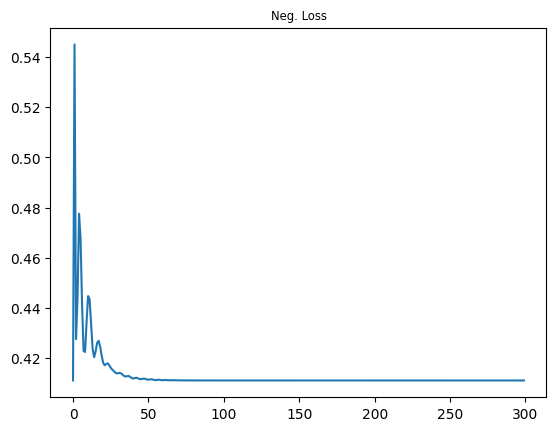

In [92]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 300#500
loss_list = []
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    loss_list.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

plt.plot(loss_list)
plt.title('Neg. Loss', fontsize='small')

In [93]:
t_test_y = torch.Tensor(df_y_test.to_numpy())

if x_scale_option != 'no-x-scale':
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_test_x = torch.Tensor(df_X_test.to_numpy())


# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [94]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [95]:
if y_scale_option=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = y_scaler.inverse_transform(t_train_y)
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()

    arr_train_mean = y_scaler.inverse_transform(train_mean)
    arr_train_lower = y_scaler.inverse_transform(train_lower)
    arr_train_upper = y_scaler.inverse_transform(train_upper)

    arr_test_mean = y_scaler.inverse_transform(test_mean)
    arr_test_lower = y_scaler.inverse_transform(test_lower)
    arr_test_upper = y_scaler.inverse_transform(test_upper)

         _Dimer_HMW_1  _Monomer_1  _Dimer_HMW_2  _Monomer_2  _Dimer_HMW_3  \
MAE              0.13        0.17          0.11        0.14          0.18   
MAE2             0.07        0.18          0.06        0.11          0.12   
MSE              0.03        0.04          0.03        0.03          0.04   
RMSE             0.16        0.19          0.16        0.18          0.21   
MAPE             0.06        0.00          0.07        0.00          0.07   
MAXE             0.25        0.28          0.33        0.33          0.37   
EVS              0.97        0.95          0.23        0.04          0.95   
R2               0.96        0.95          0.16        0.04          0.94   
AVG_STD          0.36        0.01          0.24        0.01          0.45   
MIN_STD          0.17        0.01          0.14        0.00          0.30   
MAX_STD          0.63        0.02          0.41        0.01          0.68   

         _Monomer_3  
MAE            0.59  
MAE2           0.75  
MSE      

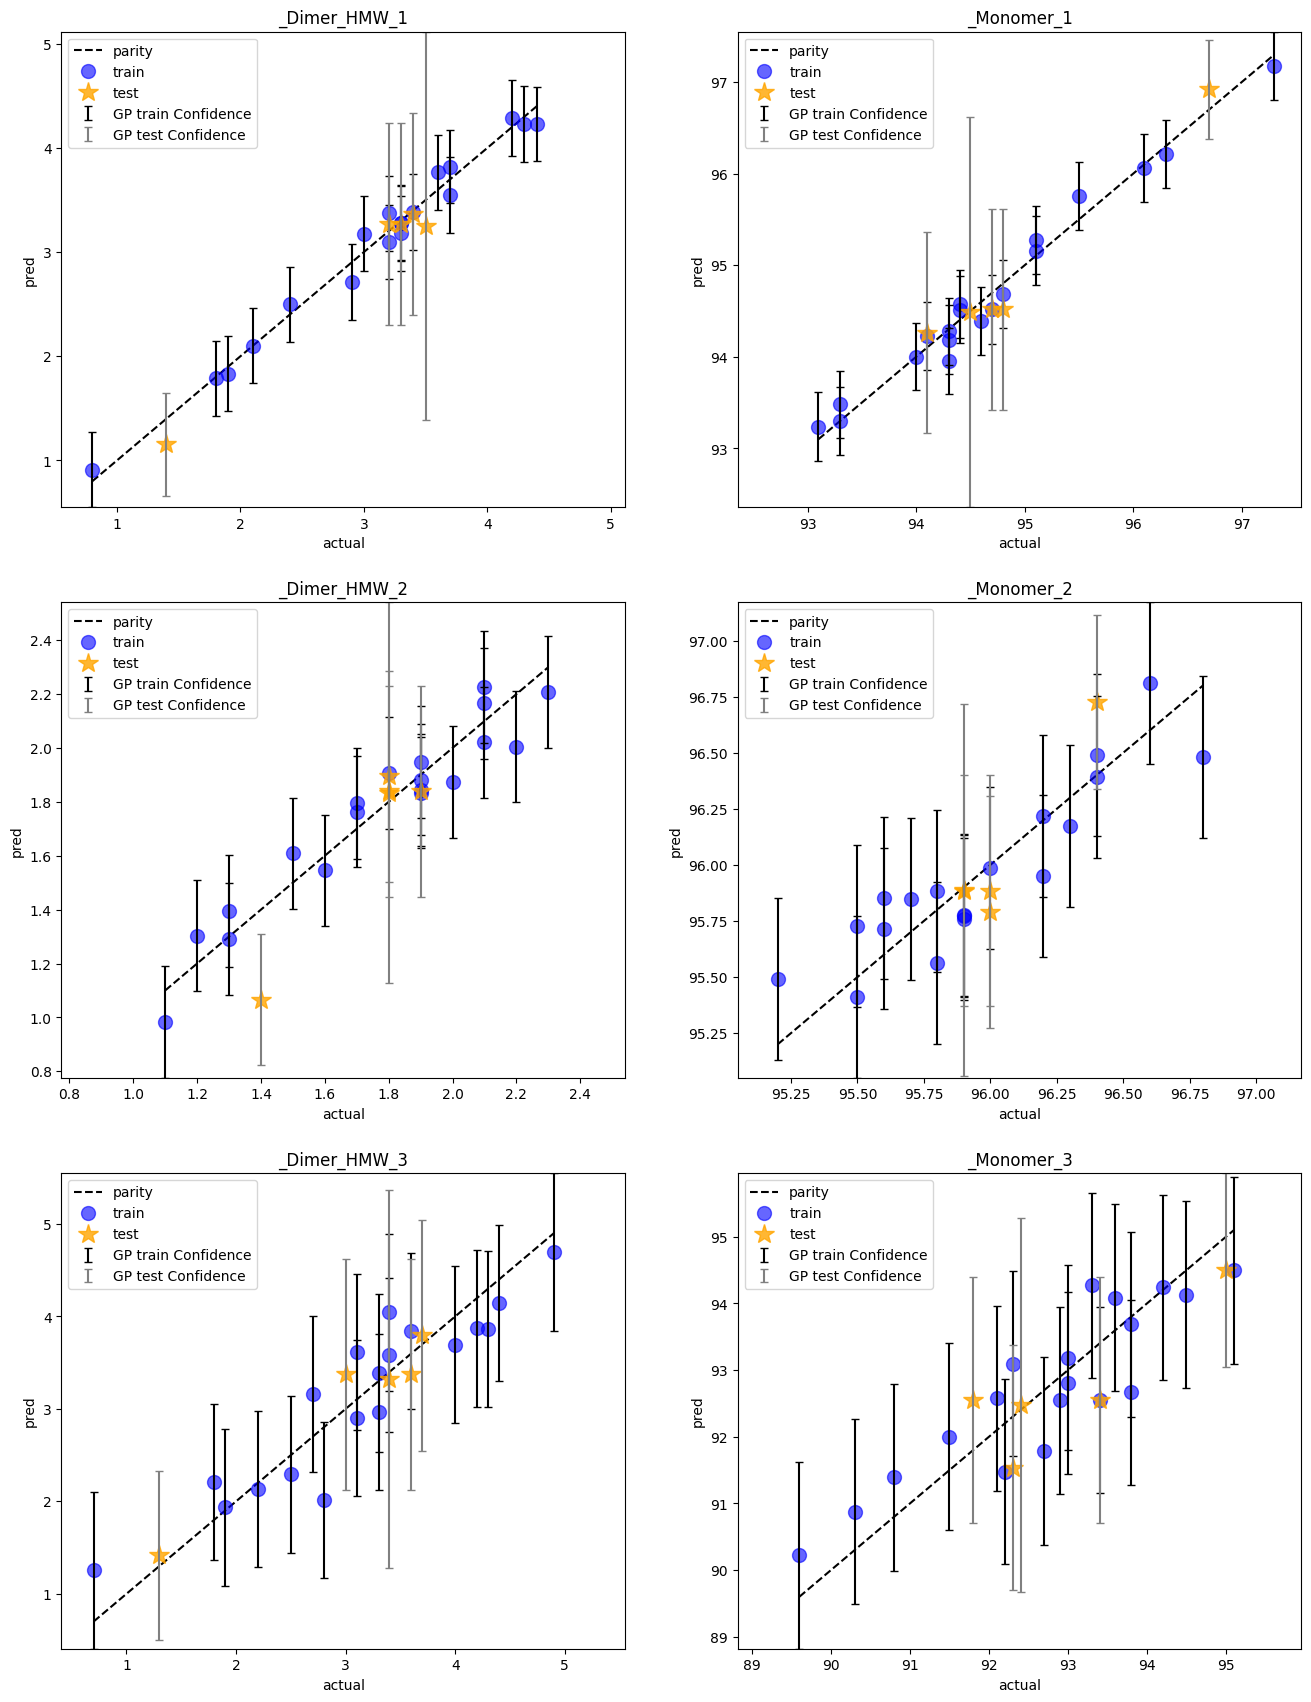

In [96]:
#from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_new = ['_Dimer_HMW_1', '_Monomer_1',
       '_Dimer_HMW_2', '_Monomer_2', 
       '_Dimer_HMW_3','_Monomer_3']

plot_axis_lb = total_df_y_long.min(axis = 0) - 0.4 * total_df_y_long.std(axis = 0)
plot_axis_ub = total_df_y_long.max(axis = 0) + 0.4 * total_df_y_long.std(axis = 0)

#num_outputs = arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))
num_outputs = len(cols_target)
num_tasks = 3

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]

    r_train_y = arr_train_y[:,a]
    r_train_mean_y =arr_train_mean[:,a]
    r_train_lower_y =arr_train_lower[:,a]
    r_train_upper_y =arr_train_upper[:,a]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[:,a]
    r_test_mean_y =arr_test_mean[:,a]
    r_test_lower_y =arr_test_lower[:,a]
    r_test_upper_y =arr_test_upper[:,a]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)
    

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'o', alpha = 0.6, color = 'blue',markersize=10)
    #sns.pointplot(data = df_train_comp, x = 'true', y = 'pred', markers = 'o', linestyles = '',ax = y_axes[a])
    # Plot test data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], '*', alpha = 0.8, color = 'orange',markersize=15)
    # Predictive mean as blue line
    #y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      df_train_comp['err'] = yerr_train
      yerr_train = yerr_train.values.tolist()
      
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      df_test_comp['err'] = yerr_test
      yerr_test = yerr_test.values.tolist()
      
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      df_comp_sorted['err'] = yerr
      yerr = yerr.values.tolist()
     
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=3, fmt='none', ecolor = 'black')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=3, fmt="none", ecolor = 'gray')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])
    else:
      arr_comp = df_comp[df_comp.columns.difference(['mode'])].to_numpy()
      axis_max = arr_comp.max()
      axis_min = arr_comp.min()
      y_axes[a].set_xlim([axis_min,axis_max])
      y_axes[a].set_ylim([axis_min,axis_max])

    #y_axes[a].legend(['parity','train','test','GP Mean','GP train Confidence','GP test Confidence'])
    y_axes[a].legend(['parity','train','test','GP train Confidence','GP test Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std)/np.mean(y_true),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std)/np.mean(y_train),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

In [35]:
for name, param in model.named_parameters():
        print(f"Parameter Name: {name}, Shape: {param.shape}")


Parameter Name: likelihood.task_noise_covar_factor, Shape: torch.Size([6, 1])
Parameter Name: likelihood.raw_noise, Shape: torch.Size([1])
Parameter Name: mean_module.base_means.0.raw_constant, Shape: torch.Size([])
Parameter Name: mean_module.base_means.1.raw_constant, Shape: torch.Size([])
Parameter Name: mean_module.base_means.2.raw_constant, Shape: torch.Size([])
Parameter Name: mean_module.base_means.3.raw_constant, Shape: torch.Size([])
Parameter Name: mean_module.base_means.4.raw_constant, Shape: torch.Size([])
Parameter Name: mean_module.base_means.5.raw_constant, Shape: torch.Size([])
Parameter Name: covar_module.task_covar_module.covar_factor, Shape: torch.Size([6, 2])
Parameter Name: covar_module.task_covar_module.raw_var, Shape: torch.Size([6])
Parameter Name: covar_module.data_covar_module.raw_lengthscale, Shape: torch.Size([1, 1])


In [67]:
#print('num_tasks',num_tasks)
print('num_outputs',num_outputs*num_tasks)

x = t_train_x
y = t_train_y
mean_x = model.mean_module(x)
print('mean_x.shape',mean_x.shape) #(N_sample, N_output)
print('y.shape',y.shape) #(N_sample, N_output)

task_kern = model.covar_module
#the following two matrices are randomly intiated
covar_factor = model.covar_module.task_covar_module.covar_factor #this is the W matrix (B = WW^T + diag(v))
v = model.covar_module.task_covar_module.raw_var
print('W.shape',covar_factor.shape)
print('v.shape',v.shape)

print('B= W W^T + diag(v) is the task kernel covariance matrix: ')
B = task_kern.task_covar_module.covar_matrix.evaluate()
print('B(T,T).shape',B.shape) #N_output


covar_data_value = model.covar_module.data_covar_module(x).evaluate()
print('K(X,X).shape',covar_data_value.shape) #N_sample

covar_x_value = task_kern(x).evaluate()
#K = K_{TT} \otimes K_{XX}
print('K.shape',covar_x_value.shape) #N_sample*N_output


num_outputs 6
mean_x.shape torch.Size([19, 6])
y.shape torch.Size([19, 6])
W.shape torch.Size([6, 2])
v.shape torch.Size([6])
B= W W^T + diag(v) is the task kernel covariance matrix: 
B(T,T).shape torch.Size([6, 6])
K(X,X).shape torch.Size([19, 19])
K.shape torch.Size([114, 114])


In [164]:
t_test_y = torch.Tensor(scaled_y_test)

if True:
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_84418/24008882.py:129: RuntimeWarning: divide by zero encountered in scalar divide
  arr_train_metrics[8,a] = round(np.mean(r_train_std)/np.mean(y_train),2)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_84418/24008882.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  arr_train_metrics[9,a] = round(np.min(r_train_std)/np.mean(y_train),2)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_84418/24008882.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  arr_train_metrics[10,a] = round(np.max(r_train_std)/np.mean(y_train),2)


         _Dimer_HMW_1  _Monomer_1  _Dimer_HMW_2  _Monomer_2  _Dimer_HMW_3  \
MAE              0.43        0.55      0.500000        0.46          0.52   
MAE2             0.29        0.42      0.510000        0.15          0.57   
MSE              0.27        0.39      0.380000        0.60          0.34   
RMSE             0.52        0.63      0.620000        0.78          0.58   
MAPE             0.62        4.15      1.000000        0.98          1.81   
MAXE             0.93        0.97      1.140000        1.69          0.84   
EVS              0.70        0.59      0.580000        0.58          0.81   
R2               0.66        0.54      0.570000        0.36          0.05   
AVG_STD          4.45       -4.01   -159.240005        4.04          2.10   
MIN_STD          2.33       -2.26   -117.669998        3.18          0.85   
MAX_STD          7.33       -6.39   -216.929993        5.24          3.74   

         _Monomer_3  
MAE            0.46  
MAE2           0.20  
MSE      

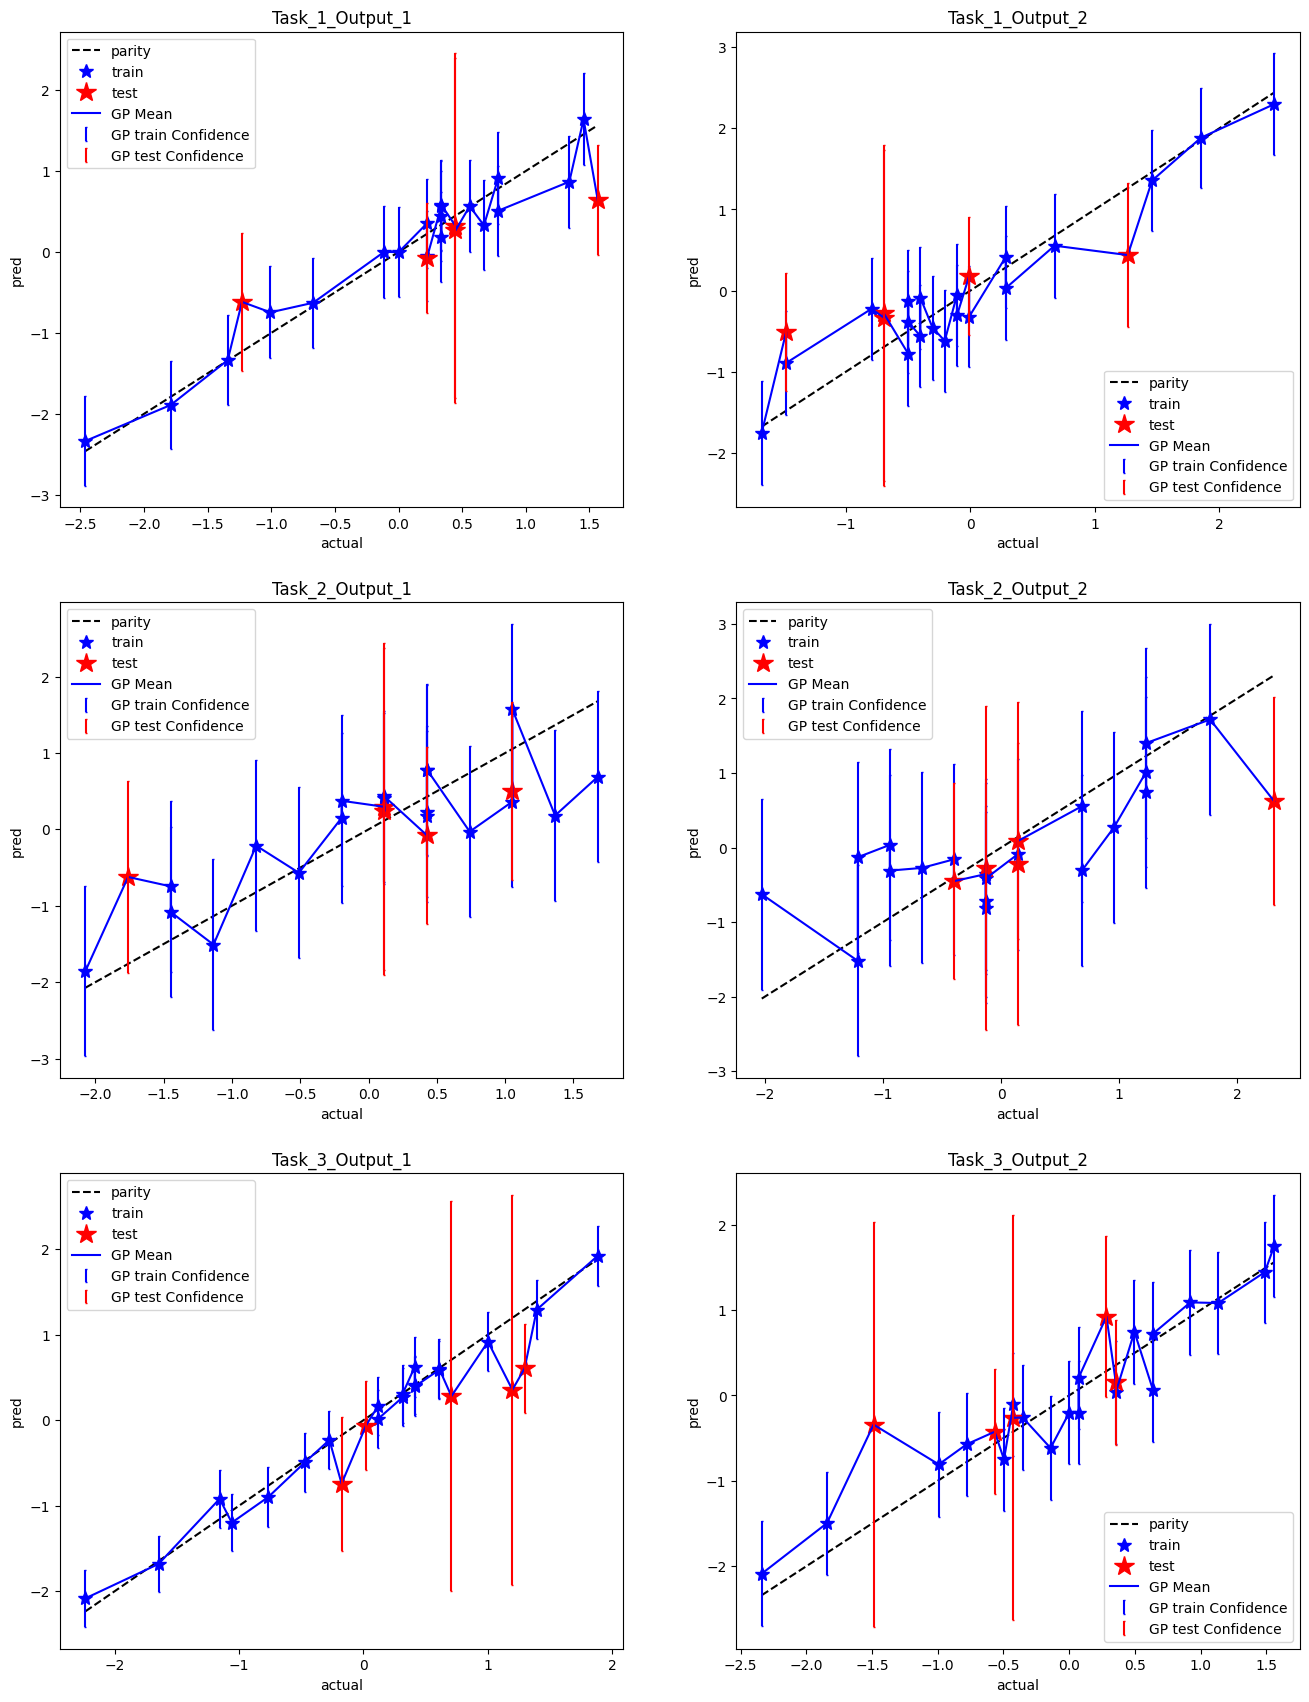

In [166]:
#from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = True
cols_target_new = ['_Dimer_HMW_1', '_Monomer_1',
       '_Dimer_HMW_2', '_Monomer_2', 
       '_Dimer_HMW_3','_Monomer_3']

#plot_axis_lb = total_df_y_long.min(axis = 0) - 0.4 * total_df_y_long.std(axis = 0)
#plot_axis_ub = total_df_y_long.max(axis = 0) + 0.4 * total_df_y_long.std(axis = 0)

num_outputs = len(cols_target)
num_tasks = 3

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j,_ in enumerate(cols_target):
    a = j + len(cols_target)*task_ind
    tmp_col_y = cols_target_new[a]

    r_train_y = arr_train_y[:,a]
    r_train_mean_y =arr_train_mean[:,a]
    r_train_lower_y =arr_train_lower[:,a]
    r_train_upper_y =arr_train_upper[:,a]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[:,a]
    r_test_mean_y =arr_test_mean[:,a]
    r_test_lower_y =arr_test_lower[:,a]
    r_test_upper_y =arr_test_upper[:,a]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'b*',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'r*',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      if y_scale_label == 'y_minmax':
        y_axes[a].set_xlim([0,1])
        y_axes[a].set_ylim([0,1])
      elif y_scale_label == 'y_stand':
        y_axes[a].set_xlim([-2.5,2.5])
        y_axes[a].set_ylim([-2.5,2.5])
    else:
      arr_comp = df_comp[df_comp.columns.difference(['mode'])].to_numpy()
      axis_max = arr_comp.max()
      axis_min = arr_comp.min()
      y_axes[a].set_xlim([axis_min,axis_max])
      y_axes[a].set_ylim([axis_min,axis_max])

    y_axes[a].legend(['parity','train','test','GP Mean','GP train Confidence','GP test Confidence'])
    #y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_title('Task_'+str(task_ind+1) + '_Output_'+str(j+1))
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std)/np.mean(y_true),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std)/np.mean(y_train),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']




if is_set_axis_limit:
  plt.savefig(figPath+'/scaled_true-pred-errorbar.jpg')
else:
  plt.savefig(figPath+'/scaled_true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_new, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/scaled_df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/scaled_df_test_metrics.csv')